In [15]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde

from pathlib import Path
from scipy import optimize
from scipy.integrate import solve_ivp
from deepxde.backend import tf

sns.set_theme(style="whitegrid")

In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import deepxde as dde

from pathlib import Path
from scipy import optimize
from scipy.integrate import solve_ivp
from deepxde.backend import tf

sns.set_theme(style="whitegrid")

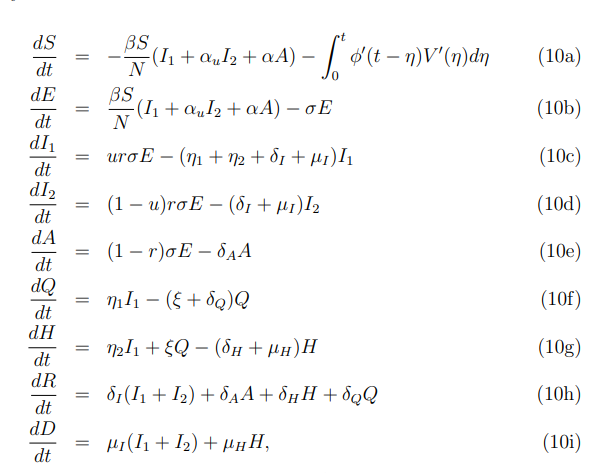

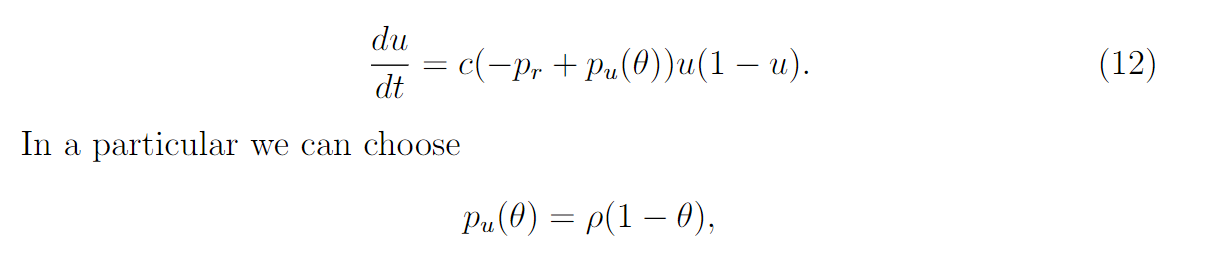

In [17]:
def phi(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (np.exp(-b * t) - np.exp(-c * t))

def dphi_dt(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (-b * np.exp(-b * t) + c * np.exp(-c * t))

def v_poly(t, v1, v2):
    return v1 * (1 - v2 / (v2 + t ** 4))

def dv_dt(t, v1, v2):
    return (4 * v1 * v2 * t ** 3) / ((v2 + t ** 4) ** 2)

def integral_dv_dphi(t, b, c, v1, v2):
    d_eta = 0.1
    eta_array = np.arange(d_eta, t + d_eta, d_eta)
    value = np.sum(dphi_dt(t - eta_array, b, c) * dv_dt(eta_array, v1, v2))
    return value * d_eta

vintegral_dv_dphi = np.vectorize(integral_dv_dphi)

def p_u(theta, rho):
    return rho * (1 - theta)

def generate_data(
    t_array,
    y0,
):
    def func(t, y):
        S, E, I1, I2, A, Q, H, R, D, U = y
        dS_dt = -beta * S * (I1 + alpha_u * I2 + alpha * A) - integral_dv_dphi(t, phi_b, phi_c, v1, v2)
        dE_dt = beta * S * (I1 + alpha_u * I2 + alpha * A) - sigma * E
        dI1_dt = U * r * sigma * E - (eta_1 + eta_2 + delta_I + mu_I) * I1
        dI2_dt = (1 - U) * r * sigma * E - (delta_I + mu_I) * I2
        dA_dt = (1 - r) * sigma * E - delta_A * A
        dQ_dt = eta_1 * I1 - (xi + delta_Q) * Q
        dH_dt = eta_2 * I1 + xi * Q - (delta_H + mu_H) * H
        dR_dt = delta_I * (I1 + I2) + delta_A * A + delta_H * H + delta_Q * Q
        dD_dt = mu_I * (I1 + I2) + mu_H * H
        dU_dt = c * (-p_r + p_u(theta, rho)) * U * (1 - U)
        return np.array([dS_dt, dE_dt, dI1_dt, dI2_dt, dA_dt, dQ_dt, dH_dt, dR_dt, dD_dt, dU_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

In [18]:
def tf_phi(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (tf.exp(-b * t) - tf.exp(-c * t))

def tf_dphi_dt(t, b, c):
    a = 1 / ((c / b) ** (b / (b - c)) - (c / b) ** (c / (b - c)))
    return a * (-b * tf.exp(-b * t) + c * tf.exp(-c * t))

def tf_v_poly(t, v1, v2):
    return v1 * (1 - v2 / (v2 + t ** 4))

def tf_dv_dt(t, v1, v2):
    return (4 * v1 * v2 * t ** 3) / ((v2 + t ** 4) ** 2)

In [19]:
# @tf.function
def tf_integral_dv_dphi(t_tensor, b, c, v1, v2):
  # value = tf.numpy_function(func=integral_dv_dphi, inp=[t_tensor, b, c, v1, v2], Tout=tf.float32)
  value = tf.py_function(func=vintegral_dv_dphi, inp=[t_tensor, b, c, v1, v2], Tout=tf.float32)
  return value

In [20]:
def get_variable_in_search_range(nominal, var, search_range):
    low = nominal * search_range[0]
    up = nominal * search_range[1]
    scale = (up - low) / 2
    tanh_var = tf.tanh(var) if isinstance(var, tf.Variable) else np.tanh(var)
    return scale * tanh_var + scale + low

In [21]:
def dinn(
    data_t,
    data_y,
    parameters,
    hyperparameters,
    experiment_name
):

    # Variables
    _beta = dde.Variable(0.0)
    # _sigma = dde.Variable(0.0)
    # _r = dde.Variable(0.0)
    # _alpha = dde.Variable(0.0)
    # _eta_1 = dde.Variable(0.0)
    # _eta_2 = dde.Variable(0.0)
    # _xi = dde.Variable(0.0)
    # _delta_I = dde.Variable(0.0)
    # _mu_I = dde.Variable(0.0)
    _delta_A = dde.Variable(0.0)
    # _delta_H = dde.Variable(0.0)
    # _mu_H = dde.Variable(0.0)
    # _delta_Q = dde.Variable(0.0)
    # phi_b = dde.Variable(0.1)
    # phi_c = dde.Variable(0.01)
    # _alpha_u = dde.Variable(0.0)
    # _c = dde.Variable(0.0)
    # _p_r = dde.Variable(0.0)
    _theta = dde.Variable(0.0)
    # _rho = dde.Variable(0.0)

    variables_list = [
        _beta,
        # _sigma,
        # _r,
        # _alpha,
        # _eta_1,
        # _eta_2,
        # _xi,
        # _delta_I,
        # _mu_I,
        _delta_A,
        # _delta_H,
        # _mu_H,
        # _delta_Q,
        # phi_b,
        # phi_c,
        # _alpha_u,
        # _c,
        # _p_r,
        _theta,
        # _rho
    ]

    # ODE model
    def ode(t, y):

        beta = get_variable_in_search_range(parameters["beta"], _beta, hyperparameters["search_range"])
        # sigma = get_variable_in_search_range(parameters["sigma"], _sigma, hyperparameters["search_range"])
        # r = get_variable_in_search_range(parameters["r"], _r, hyperparameters["search_range"])
        # alpha = get_variable_in_search_range(parameters["alpha"], _alpha, hyperparameters["search_range"])
        # eta_1 = get_variable_in_search_range(parameters["eta_1"], _eta_1, hyperparameters["search_range"])
        # eta_2 = get_variable_in_search_range(parameters["eta_2"], _eta_2, hyperparameters["search_range"])
        # xi = get_variable_in_search_range(parameters["xi"], _xi, hyperparameters["search_range"])
        # delta_I = get_variable_in_search_range(parameters["delta_I"], _delta_I, hyperparameters["search_range"])
        # mu_I = get_variable_in_search_range(parameters["mu_I"], _mu_I, hyperparameters["search_range"])
        delta_A = get_variable_in_search_range(parameters["delta_A"], _delta_A, hyperparameters["search_range"])
        # delta_H = get_variable_in_search_range(parameters["delta_H"], _delta_H, hyperparameters["search_range"])
        # mu_H = get_variable_in_search_range(parameters["mu_H"], _mu_H, hyperparameters["search_range"])
        # delta_Q = get_variable_in_search_range(parameters["delta_Q"], _delta_Q, hyperparameters["search_range"])
        # phi_b = get_variable_in_search_range(parameters["phi_b"], _phi_b, hyperparameters["search_range"])
        # phi_c = get_variable_in_search_range(parameters["phi_c"], _phi_c, hyperparameters["search_range"])
        # alpha_u = get_variable_in_search_range(parameters["alpha_u"], _alpha_u, hyperparameters["search_range"])
        # c = get_variable_in_search_range(parameters["c"], _c, hyperparameters["search_range"])
        # p_r = get_variable_in_search_range(parameters["p_r"], _p_r, hyperparameters["search_range"])
        theta = get_variable_in_search_range(parameters["theta"], _theta, hyperparameters["search_range"])
        # rho = get_variable_in_search_range(parameters["rho"], _rho, hyperparameters["search_range"])

        S = y[:, 0:1]
        E = y[:, 1:2]
        I1 = y[:, 2:3]
        I2 = y[:, 3:4]
        A = y[:, 4:5]
        Q = y[:, 5:6]
        H = y[:, 6:7]
        R = y[:, 7:8]
        D = y[:, 8:9]
        U = y[:, 9:10]

        dS_dt = dde.grad.jacobian(y, t, i=0)
        dE_dt = dde.grad.jacobian(y, t, i=1)
        dI1_dt = dde.grad.jacobian(y, t, i=2)
        dI2_dt = dde.grad.jacobian(y, t, i=3)
        dA_dt = dde.grad.jacobian(y, t, i=4)
        dQ_dt = dde.grad.jacobian(y, t, i=5)
        dH_dt = dde.grad.jacobian(y, t, i=6)
        dR_dt = dde.grad.jacobian(y, t, i=7)
        dD_dt = dde.grad.jacobian(y, t, i=8)
        dU_dt = dde.grad.jacobian(y, t, i=9)

        return [
            dS_dt - (-beta * S * (I1 + alpha_u * I2 + alpha * A) - tf_integral_dv_dphi(t, phi_b, phi_c, v1, v2)),
            dE_dt - (beta * S * (I1 + alpha_u * I2 + alpha * A) - sigma * E),
            dI1_dt - (U * r * sigma * E - (eta_1 + eta_2 + delta_I + mu_I) * I1),
            dI2_dt - ((1 - U) * r * sigma * E - (delta_I + mu_I) * I2),
            dA_dt - ((1 - r) * sigma * E - delta_A * A),
            dQ_dt - (eta_1 * I1 - (xi + delta_Q) * Q),
            dH_dt - (eta_2 * I1 + xi * Q - (delta_H + mu_H) * H),
            dR_dt - (delta_I * (I1 + I2) + delta_A * A + delta_H * H + delta_Q * Q),
            dD_dt - (mu_I * (I1 + I2) + mu_H * H),
            dU_dt - (c * (-p_r + p_u(theta, rho)) * U * (1 - U))
        ]

    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Boundaries
    # def boundary(_, on_initial):
    #     return on_initial

    # Initial conditions
    # S0, E0, I0, U0, A0, Q0, H0, R0, D0 = data_y[0, :]
    # ic_S = dde.icbc.IC(geom, lambda x: S0, boundary, component=0)
    # ic_E = dde.icbc.IC(geom, lambda x: E0, boundary, component=1)
    # ic_I1 = dde.icbc.IC(geom, lambda x: I10, boundary, component=2)
    # ic_I2 = dde.icbc.IC(geom, lambda x: I20, boundary, component=3)
    # ic_A = dde.icbc.IC(geom, lambda x: A0, boundary, component=4)
    # ic_Q = dde.icbc.IC(geom, lambda x: Q0, boundary, component=5)
    # ic_H = dde.icbc.IC(geom, lambda x: H0, boundary, component=6)
    # ic_R = dde.icbc.IC(geom, lambda x: R0, boundary, component=7)
    # ic_D = dde.icbc.IC(geom, lambda x: D0, boundary, component=8)
    # ic_U = dde.icbc.IC(geom, lambda x: U0, boundary, component=9)

    # Train data
    observe_S = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 0:1], component=0)
    observe_E = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 1:2], component=1)
    observe_I1 = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 2:3], component=2)
    observe_I2 = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 3:4], component=3)
    observe_A = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 4:5], component=4)
    observe_Q = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 5:6], component=5)
    observe_H = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 6:7], component=6)
    observe_R = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 7:8], component=7)
    observe_D = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 8:9], component=8)
    observe_U = dde.icbc.PointSetBC(data_t[1:, :], data_y[1:, 9:10], component=9)

    # Model
    data = dde.data.PDE(
        geom,
        ode,
        [
            # ic_S,
            # ic_E,
            # ic_I1,
            # ic_I2,
            # ic_A,
            # ic_Q,
            # ic_H,
            # ic_R,
            # ic_D,
            # ic_U,
            observe_S,
            observe_E,
            observe_I1,
            observe_I2,
            observe_A,
            observe_Q,
            observe_H,
            observe_R,
            observe_D,
            observe_U
        ],
        num_domain=256,
        num_boundary=2,
        # train_distribution="uniform",
        anchors=data_t,
    )

    neurons = hyperparameters["neurons"]
    layers = hyperparameters["layers"]
    activation = hyperparameters["activation"]
    net = dde.nn.FNN([1] + [neurons] * layers + [10], activation, "Glorot uniform")

    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=hyperparameters["loss_weights"],
        external_trainable_variables=variables_list
    )
    variable = dde.callbacks.VariableValue(
        variables_list,
        period=100,
        filename=f"{experiment_name}.dat"
    )
    losshistory, train_state = model.train(
        iterations=hyperparameters["iterations"],
        display_every=10000,
        callbacks=[variable]
    )
    # model.compile("L-BFGS", external_trainable_variables=variables_list)
    # losshistory, train_state = model.train(callbacks=[variable])
    # dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    parameters_pred = {
        name: get_variable_in_search_range(nominal, var, hyperparameters["search_range"])
        for (name, nominal), var in zip(parameters.items(), variable.value)
    }
    return model, losshistory, train_state, parameters_pred, variable

In [22]:
experiment_name = "covid19_china_under_beta_deltaa_u_function"

N = 1453477594
S0 = (N - 1 - 1) / N
E0 = 0
I10 = 1 / N
I20 = 1 / N
A0 = 0
Q0 = 0
H0 = 0
R0 = 0
D0 = 0
U0 = 0
y0 = [S0, E0, I10, I20, A0, Q0, H0, R0, D0, U0]

beta = 11
sigma = 1 / 4.35
r = 0.227
alpha = 0.43
eta_1 = 0.001
eta_2 = 0.0689
xi = 0.3
delta_I = 0.9975
mu_I = 0.0025
delta_A = 0.9975
delta_H = 0.9975
mu_H = 0.0015
delta_Q = 0.9975
phi_b = 0.231
phi_c = 0.008
v1 = 9.04733394e-01
v2 = 1.16081503e+09
alpha_u = 0.4
c = 0.8
p_r = 0.4
theta = 0.95
rho = 0.9

parameters_real = {
    "beta": beta,
    # "sigma": sigma,
    # "r": r,
    # "alpha": alpha,
    # "eta_1": eta_1,
    # "eta_2": eta_2,
    # "xi": xi,
    # "delta_I": delta_I,
    # "mu_I": mu_I,
    "delta_A": delta_A,
    # "delta_H": delta_H,
    # "mu_H": mu_H,
    # "delta_Q": delta_Q,
    # "phi_b": phi_b,
    # "phi_c": phi_c,
    # "alpha_u": alpha_u,
    # "c": c,
    # "p_r": p_r,
    "theta": theta,
    # "rho": rho
}

hyperparameters = {
    "search_range": (0.2, 1.8),
    "iterations": 50000,
    "layers": 5,
    "neurons": 128,
    "activation": "relu",
    "loss_weights": [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ]
}

In [23]:
n_days = 60
t_train = np.arange(n_days)[:, np.newaxis]
y_train = generate_data(t_train.ravel(), y0)

model, losshistory, train_state, parameters_pred, variable = dinn(
    data_t=t_train,
    data_y=y_train,
    parameters=parameters_real,
    hyperparameters=hyperparameters,
    experiment_name=experiment_name
)
y_pred = model.predict(t_train)

Compiling model...
Building feed-forward neural network...
'build' took 0.044229 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-06-28 09:36:43.009378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 09:36:43.009526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 09:36:43.009579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-28 09:36:43.

'compile' took 0.932868 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                                                  Test loss                                                                                                                                                                                                   Test metric
0         [8.86e-06, 2.18e-05, 1.40e-04, 1.85e-05, 1.03e-04, 1.29e-03, 1.03e-04, 8.27e-05, 3.38e-08, 2.98e-06, 5.94e-01, 1.68e-02, 1.20e-04, 2.47e-05, 9.27e-04, 7.57e-04, 7.38e-06, 2.15e-01, 5.13e-05, 9.08e-04]    [8.86e-06, 2.18e-05, 1.40e-04, 1.85e-05, 1.03e-04, 1.29e-03, 1.03e-04, 8.27e-05, 3.38e-08, 2.98e-06, 5.94e-01, 1.68e-02, 1.20e-04, 2.47e-05, 9.27e-04, 7.57e-04, 7.38e-06, 2.15e-01, 5.13e-05, 9.08e-04]    []  
10000     [5.70e-06, 5.73e-06, 3.48e-06, 6.27e-07, 1.24e-06, 5.52e-07, 3.91

In [24]:
model_name = "SEI1I2AQHRDU"
populations_names = [
    "S",
    "E",
    "I1",
    "I2",
    "A",
    "Q",
    "H",
    "R",
    "D",
    "U"
]
data_real = (
    pd.DataFrame(y_train, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

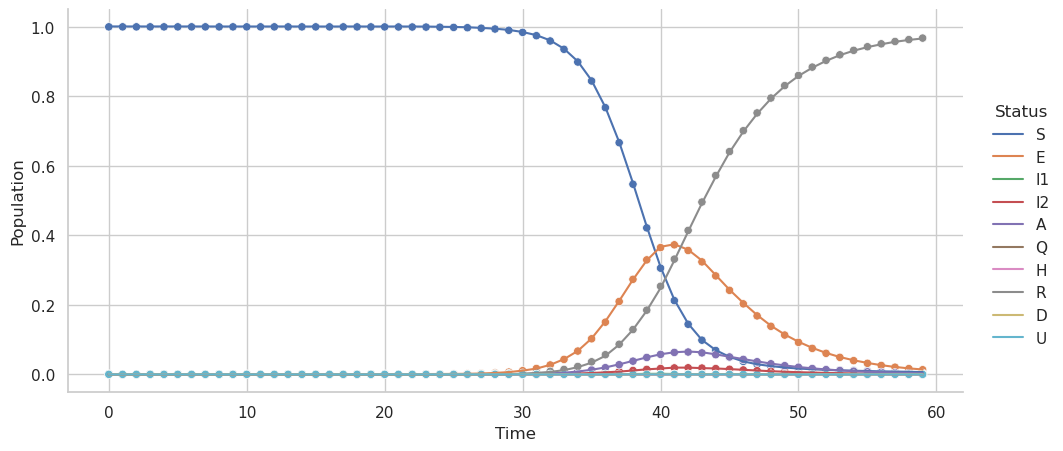

In [25]:
g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle(f"{model_name} model estimation")
g.savefig(f"{model_name}_model_estimation_{experiment_name}.png", dpi=300)
plt.show()

In [26]:
lines = open(f"{experiment_name}.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {
    name: get_variable_in_search_range(nominal, raw_parameters_pred_history[:, i], hyperparameters["search_range"])
    for i, (name, nominal) in enumerate(parameters_real.items())
}

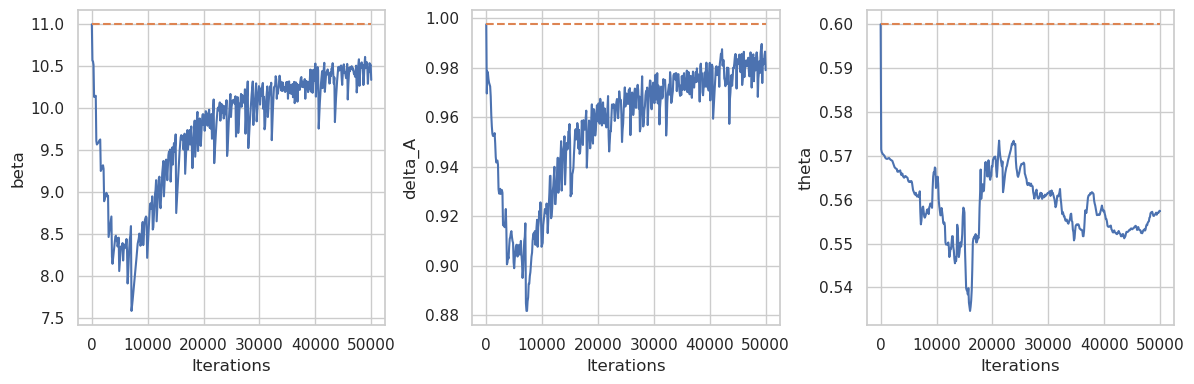

In [27]:
n_callbacks, n_variables = raw_parameters_pred_history.shape
n_cols = len(parameters_real)
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 4))
for ax, (parameter, parameter_value) in zip(axes.flatten(), parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
    ax.set_xlabel("Iterations")
fig.tight_layout()
fig.savefig(f"{model_name}_parameter_estimation_{experiment_name}.png", dpi=300)

In [28]:
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
display(error_df)
error_df.to_csv(f"{experiment_name}_relative_error.csv")

,Real,Predicted,Relative Error
beta,11.0000,10.338969,0.060094
delta_A,0.9975,0.979013,0.018534
theta,0.6000,0.557463,0.070895
